# ST311 Project Source Code
# Colourising Grayscale images with Autoencoders

Candidate Numbers: 36456, 37443

# 1. Setup

## 1.1 Imports

### 1.1.1 Imports

In [ ]:
%matplotlib inline
import csv
import glob
from IPython import display
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import random
from PIL import Image
import shutil
from skimage import color
from skimage.io import imread
import time
import torch
from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm
import urllib.request

### 1.1.2 D2L

D2L module for animator

In [ ]:
!pip install d2l==0.17.0 
from d2l import torch as d2l

     |████████████████████████████████| 83 kB 1.5 MB/s 


### 1.1.3 Mount Google Drive

In [ ]:
import cv2
from google.colab import drive
from google.colab import files
from google.colab.patches import cv2_imshow
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## 1.2 Define Paths

In [ ]:
%cd /content/drive/MyDrive/ST311 Project
gdrivesource = "./dataset_1/unsplash_lite_source/unsplash-research-dataset-lite-latest/photos.tsv000"
gdrivepath_unsplash_photos = "./dataset_1/unsplash_lite_photos/*.jpg"
gdrivepath_unsplash_photos_master = "./dataset_1/unsplash_lite_photos_master/*.jpg"
gdrivepath_unsplash_photos_cleaned = "./dataset_1/unsplash_lite_photos_cleaned_3/*.jpg"
gdrivepath_index_full = "./dataset_1/index.csv"
gdrivepath_index_relative = "./dataset_1/index3.csv"

/content/drive/MyDrive/ST311 Project


# 2. Download Photos from Source

### 2.1 Parse URLs
Source of dataset: https://github.com/unsplash/datasets.

The dataset consists of a number of CSV files. The `photos.tsv000` file contains the URL to each image, along with other properties of the image, such as image size, image description, camera properties and location information.

The Unsplash API have a function to access a modified version of a particular image. Using the API access token (`ixid`), we create a list of URLs to access the cropped (to square shape in the center) and subsequently scaled down version of each image to 256x256 pixels while maintaining the original aspect ratio. 


In [ ]:
# read CSV file of urls
df = pd.read_csv(gdrivesource, sep="\t", header=0)
urldict = dict(zip(df.loc[:,"photo_id"],df.loc[:,"photo_image_url"]))
for id, url in urldict.items():
  # ixid to access Unsplash API
  # Crop each image to 256x256 pixels and maintain original aspect ratio
  urldict[id] = url + "?ixid=2yJhcHBfaWQiOjEyMDd9&&fm=jpg&fit=crop&w=256&h=256"

### 2.2 Download Images

Download the images from the URLs generated in the previous section. In total, there are 24,996 images in this dataset.

In [ ]:
for id, url in urldict.items():
  # generate paths from photo ids
  path = os.path.join("./dataset_1/unsplash_lite_photos/", id + ".jpg")
  # if image already exists in directory, do not reimport
  if os.path.exists(path):
    continue
  else:
    # try to download that image
    try: 
      urllib.request.urlretrieve(url, path)
    # if unable to download that image, skip
    except Exception:
      continue
print(len(os.listdir("./dataset_1/unsplash_lite_photos/")))

### 2.3 Duplicate for Safekeeping

Make a copy of the folder of images. We maintain one master copy of the complete dataset, and one copy for manipulation (filtering images).

In [ ]:
source_folder = "./dataset_1/unsplash_lite_photos/"
destination_folder = "./dataset_1/unsplash_lite_photos_master/"

for file_name in os.listdir(source_folder):
  source = source_folder + file_name
  destination = destination_folder + file_name
  if os.path.exists(destination):
    continue
  elif os.path.isfile(source):
    shutil.copy(source, destination)
  else:
    continue
print(len(os.listdir("./dataset_1/unsplash_lite_photos_master/")))

In [ ]:
source_folder = "./dataset_1/unsplash_lite_photos/"
destination_folder = "./dataset_1/unsplash_lite_photos_cleaned_3/"

for file_name in os.listdir(source_folder):
  source = source_folder + file_name
  destination = destination_folder + file_name
  if os.path.exists(destination):
    continue
  elif os.path.isfile(source):
    shutil.copy(source, destination)
  else:
    continue
print(len(os.listdir("./dataset_1/unsplash_lite_photos_cleaned_3/")))

### 2.4 Filter Images
We filter images based on the following criteria:
1. Nothing that is overall too dark (black)
2. Nothing that is overall too bright (white)
3. Nothing that contains too much of a single colour

#### 2.4.1 Rank images based on overall brightness

The dataset also contains a file `colors.tsv000`. The top ten colours (given as RGB and HEX values) contained in each image, with their coverage as a percentage is given for each image in the dataset. 

We convert the RGB values to CIELAB values, as L represent the (perceptual) brightness of a colour. We then calculate a weighted coverage of each colour in a given image. The final weighted value is between the range of 0 and 100. 

In [ ]:
color_composition = pd.read_csv("./dataset_1/unsplash_lite_source/unsplash-research-dataset-lite-latest/colors.tsv000", sep="\t", header=0)

def rgbtolab(r, g, b):
  """ Defined in 'colors.tsv000'.
  `r`, `g`, `b`: Corresponds to RGB values of a particular colour. 
  """
  colors = [r/255, g/255, b/255] # Normalise from [0, 255] to [0, 1]
  return color.rgb2lab(colors)

def l_weighted(lab, ai_coverage):
  """ Defined in `colors.tsv000`.
  `lab`: CIELAB values of a particular colour. 
  `ai_coverage`: Coverage of the colour defined by `lab`.
  """
  l_value = lab[0] 
  return l_value*ai_coverage

# Convert RGB to CIELAB colour values
color_composition['lab'] = color_composition.apply(lambda x: rgbtolab(x.red, x.green, x.blue), axis=1)

# Calculate (weighted) coverage of a colour in a given image
color_composition['l_weighted'] = color_composition.apply(lambda x: l_weighted(x.lab, x.ai_coverage), axis=1)
color_composition.head()

In [ ]:
# Group by photo_id
color_composition_grouped = color_composition.groupby('photo_id')['l_weighted'].sum().sort_values()
print(color_composition_grouped.head())
print(color_composition_grouped.tail())
len(color_composition_grouped)

In [ ]:
display_photo(color_composition_grouped.index[500])

In [ ]:
color_composition_grouped.to_csv('overall_brightness.csv')
!cp overall_brightness.csv "drive/MyDrive/ST311 Project/"

#### 2.4.2 Remove bad images from training data
Based on the criteria above, we remove the following images:
- the 1,000 brightest images (mainly containly whites)
- the 500 darkest images (mainly contain blacks)
- any image that contains 90+% of the same colour 

Of the 24,996 images, 1,705 images are removed, leaving us with 23,291 images.

In [ ]:
# Select the 1000 brightest images
bad_photos_ids_1 = list(color_composition_grouped.index[:1000])
# Select the 500 darkest images
bad_photos_ids_2 = list(color_composition_grouped.index[-500:])
# Select images containing over 90% of the same colour 
bad_photos_ids_3 = list(color_composition[color_composition['ai_coverage'] >= 0.9]['photo_id'])
bad_photo_ids = bad_photos_ids_1 + bad_photos_ids_2 + bad_photos_ids_3
bad_photo_ids = set(bad_photo_ids)
len(bad_photo_ids)

In [ ]:
print(len(os.listdir(f'./dataset_1/unsplash_lite_photos_master/')))
print(len(os.listdir(f'./dataset_1/unsplash_lite_photos_cleaned_3')))

24996
23291


In [ ]:
for i in bad_photo_ids:
  try:
    os.remove(f"./dataset_1/unsplash_lite_photos_cleaned_3/{i}.jpg")
  except:
    print("Error while deleting file : ", f'{i}.jpg')

In [ ]:
print(len(os.listdir(f'./dataset_1/unsplash_lite_photos_cleaned_3')))

### 2.5 Create CSV file of URLs

To speed up access the images in the folder, create a CSV file containing the URLs to each image.

In [ ]:
listdir = os.listdir("./dataset_1/unsplash_lite_photos_cleaned_3")
listurl = ["./dataset_1/unsplash_lite_photos_cleaned_3/" + s for s in listdir]
np.savetxt("./dataset_1/index3.csv", listurl, delimiter=",", fmt="% s")

In [ ]:
df = pd.read_csv("./dataset_1/index3.csv")
print(len(df))
df.iloc[1][0]

23290


'./dataset_1/unsplash_lite_photos_cleaned_3/xCsUiY9iDlE.jpg'

### 2.6 Function to display a single image
Function to confirm the images are downloaded correctly and display images.

In [ ]:
def display_photo(photo_id):
  """ Defined in `photos.tsv000`.
  `photo_id`: Same as name of file. 
  """
  photo_path = f'./dataset_1/unsplash_lite_photos/{photo_id}.jpg'
  img = cv2.imread(photo_path)
  print(img.shape)
  return cv2_imshow(img)

# 3. Creating the dataset and dataloader

We create a custom PyTorch dataset and dataloader for our data. The following is two different implementations of a PyTorch dataset and dataloader. The difference in the two dataloaders is in the usage of multiprocessing. Otherwise the overall implementation is the same:
- Version 1 is the naive implementation of PyTorch dataset and dataloader.

- Version 2 implements multiprocessing to speed up the creation of the dataloader. However, due to CPUs on Google Colab being only dual-core, the increase in speed is limited. The part of code that is multi-processed is the image converter.

The images are pre-processed according to the following steps:
1. Convert JPG image into a Numpy array of RGB values
2. Convert RGB values to CIELAB values
3. Normalise CIELAB values to be in range (-1, 1)
4. Seperate the **L** (perceptual brightness) channel from the **A, B** (colours) channels

## 3.1 Dataloader 1 (Slow)

In [ ]:
class Dataset(torch.utils.data.TensorDataset):
  def __init__(self, index, samples):
    self.data = []
    with open(index, "r") as indicies:
      id = indicies.read().split("\n")
    pbar = tqdm(total=samples, position=0, 
                  bar_format="Importing images: {n_fmt}/{total_fmt} ({percentage:3.0f}%) [{elapsed}/{remaining}]{bar}{desc}")
    for j in random.sample(id, samples):
      try:
        pbar.set_description(f"Processing {j}")
        convimg = self.imageloader(j)
        self.data.append(convimg)
        pbar.update(1)
      except:
        continue

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]
  
  def imageloader(self, img):
    im = imread(img) 
    lab = color.rgb2lab(1.0 * im / 255) # normalize from [0, 255] to [0, 1]
    lab = torch.Tensor(lab)
    lab = torch.permute(lab,(2,0,1)) #color
    l = lab[0,:,:]
    l = torch.reshape(l,(1, 1, 256, 256)) #l
    l.requires_grad_(True)
    ab = lab[1:,:,:]
    ab = ab/128
    ab = torch.reshape(ab,(1, 2, 256, 256)) #ab    
    ab.requires_grad_(True)
    return [[ab, l]]

def load_array(index, n, splitratio=0.1, batchsize=100):
  """ Load the dataset
  `index`: Index file containing all paths in the dataset object
  `n`: Number of samples
  `splitratio` (optional, default: `0.1`): Proportion of `n` to be allocated as validation set. Must be between 0 and 1.
  `batchsize` (optional, default: `100`): Number of samples per batch. Last batch contains leftovers
  """
  if __name__ == '__main__':
    dataset = Dataset(index, n) # Create dataset object
    indicies = list(range(n)) # Generate indices up to required number of samples
    split = int(np.floor(splitratio * n)) # Calculate number require for training and validation sets
    np.random.shuffle(indicies) # Randomly shuffle indicies
    train_idx, valid_idx = indicies[split:n], indicies[:split] # Split indicies into training and testing sets

    # Define sampler
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx) 

    # Create dataloader
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, sampler=train_sampler) 
    validloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, sampler=valid_sampler) 
    return trainloader, validloader 

## 3.2 Dataloader 2 (Fast)

In [ ]:
def process_image(img):
  # we know that file must exist since we generated a list of file names in that directory
  # infinite while loop since Google Drive sometimes take multiple tries to successfully read a file in the directory
  while True:
    try:
      im = imread(img)
      # Convert from RGB to CIELAB 
      lab = color.rgb2lab(1.0 * im / 255) # normalize from [0, 255] to [0, 1]
      lab = torch.Tensor(lab)
      lab = torch.permute(lab,(2,0,1)) # move number of channels to the 0-th dimension
      l = lab[0,:,:]
      l = torch.reshape(l,(1, 1, 256, 256)) #l channel
      l.requires_grad_(True)
      ab = lab[1:,:,:]
      ab = ab/128 # normalise from [-128, 128] to [-1, 1]
      ab = torch.reshape(ab,(1, 2, 256, 256)) #a, b channels
      ab.requires_grad_(True)
      return [[ab, l]]
    except:
      pass

class Dataset(torch.utils.data.TensorDataset):
  def __init__(self, index, samples):
    self.data = []
    df = pd.read_csv(index, header=None) # read CSV file of path paths
    id = df[0].tolist() # convert single column dataframe to list
    self.randomlist = random.sample(id, samples) # randomise list
    self.randomitr = iter(self.randomlist) # create iterator object from list
    self.samples = samples
    self.run() # execute multi-processing 
  
  def run(self):
    results = []
    with Pool() as pool:
      for result in tqdm(pool.imap_unordered(process_image, self.randomitr), total=self.samples):
        results.append(result)
      pool.close()
      pool.join()
    filterpool = list(filter(None, results)) # filer unsuccessful attempts
    self.data += filterpool
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx]

def load_array(index, n, splitratio=0.1, batchsize=100):
  """ Load the dataset
  `index`: Index file containing all paths in the dataset object
  `n`: Number of samples
  `splitratio` (optional, default: `0.1`): Proportion of `n` to be allocated as validation set. Must be between 0 and 1.
  `batchsize` (optional, default: `100`): Number of samples per batch. Last batch contains leftovers
  """
  if __name__ == "__main__":
    dataset = Dataset(index, n) # Create dataset object
    indicies = list(range(n)) # Generate indices up to required number of samples
    split = int(np.floor(splitratio * n)) # Calculate number require for training and validation sets
    np.random.shuffle(indicies) # Randomly shuffle indicies
    train_idx, valid_idx = indicies[split:n], indicies[:split] # Split indicies into training and testing sets

    # Define sampler
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx) 

    # Create dataloader
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, sampler=train_sampler) 
    validloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, sampler=valid_sampler) 
    return trainloader, validloader 

# 4. Autoencoder

## 4.1 Model 0 (Baseline)

### 4.1.1 Model 0
A simple convolutional autoencoder.

In [ ]:
class Autoencoder0(nn.Module):
  def __init__(self):
    super().__init__()        
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1), nn.ReLU(),    # (  1,256,256) -> ( 64,128,128)
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # ( 64,128,128) -> (128,128,128)
      nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(), # (128,128,128) -> (256, 64, 64)
      nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(), # (256, 64, 64) -> (256, 32, 32)
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nn.ReLU(), # (256, 32, 32) -> (512, 32, 32)
    )
    self.decoder = nn.Sequential(
      nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(), # (512, 32, 32) -> (128, 32, 32)
      nn.Upsample(scale_factor=2),                                        # (128, 32, 32) -> (128, 64, 64)
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(),   # (128, 64, 64) -> ( 64, 64, 64)
      nn.Upsample(scale_factor=2),                                        # ( 64, 64, 64) -> ( 64,128,128)
      nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),nn.Tanh(),     # ( 64,128,128) -> ( 2,128,128)                             
      nn.Upsample(scale_factor=2)                                         # (  2,128,128) -> (  2,256,256)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### 4.1.2 Model 0T
This is the same model as in Model 0, but uses transposed convolutions layers instead of convolution followed by upsampling layers.

In [ ]:
class Autoencoder0T(nn.Module):
  def __init__(self):
    super().__init__()        
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1), nn.ReLU(),    # (  1,256,256) -> ( 64,128,128)
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # ( 64,128,128) -> (128,128,128)
      nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(), # (128,128,128) -> (256, 64, 64)
      nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(), # (256, 64, 64) -> (256, 32, 32)
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nn.ReLU(), # (256, 32, 32) -> (512, 32, 32)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(), # (512, 32, 32) -> (128, 64, 64)
      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(),  # (128, 64, 64) -> ( 64,128,128)
      nn.ConvTranspose2d(64, 2, kernel_size=3, stride=2, padding=1, output_padding=1), nn.Tanh()     # ( 64,128,128) -> (  2,256,256)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### 4.1.3 Model 0B
This is a modified version of Model 0, with the addition of batch normalisation layers after every convolutional layer in both the encoder and decoder.

In [ ]:
class Autoencoder0B(nn.Module):
  def __init__(self):
    super().__init__()        
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),     # (  1,256,256) -> ( 64,128,128)
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU(),  # ( 64,128,128) -> (128,128,128)
      nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(), # (128,128,128) -> (256, 64, 64)
      nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(), # (256, 64, 64) -> (256, 32, 32)
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(), # (256, 32, 32) -> (512, 32, 32)
    )
    self.decoder = nn.Sequential(
      nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(), # (512, 32, 32) -> (128, 32, 32)
      nn.Upsample(scale_factor=2),                                        # (128, 32, 32) -> (128, 64, 64)
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # (128, 64, 64) -> ( 64, 64, 64)
      nn.Upsample(scale_factor=2),                                        # ( 64, 64, 64) -> ( 64,128,128)
      nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1), nn.Tanh(),    # ( 64,128,128) -> ( 2,128,128)                             
      nn.Upsample(scale_factor=2)                                         # (  2,128,128) -> (  2,256,256)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## 4.2 Model 1

### 4.2.1 Model 1
This is a modified version of the model proposed in https://arxiv.org/pdf/1712.03400.pdf, where the feature extractor is omitted.

Original implementation in TensorFlow (https://github.com/baldassarreFe/deep-koalarization/blob/master/src/koalarization/network_definition.py)

In [ ]:
class Autoencoder1(nn.Module):
  def __init__(self):
    super().__init__()        
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1), nn.ReLU(),    # (  1,256,256) -> ( 64,128,128)
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),  # ( 64,128,128) -> (128,128,128)
      nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(), # (128,128,128) -> (128, 64, 64)
      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(), # (128, 64, 64) -> (256, 64, 64)
      nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(), # (256, 64, 64) -> (256, 32, 32)
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nn.ReLU(), # (256, 32, 32) -> (512, 32, 32)
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nn.ReLU(), # (512, 32, 32) -> (512, 32, 32)
      nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nn.ReLU()  # (512, 32, 32) -> (256, 32, 32)
    )
    self.decoder = nn.Sequential(
      nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(), # (256, 32, 32) -> (128, 32, 32)
      nn.Upsample(scale_factor=2),                                        # (128, 32, 32) -> (128, 64, 64)
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(),   # (128, 64, 64) -> ( 64, 64, 64)
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(),    # ( 64, 64, 64) -> ( 64, 64, 64)
      nn.Upsample(scale_factor=2),                                        # ( 64, 64, 64) -> ( 64,128,128)
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),nn.ReLU(),    # ( 64,128,128) -> ( 32,128,128)
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),nn.Tanh(),     # ( 32,128,128) -> (  2,128,128)                              
      nn.Upsample(scale_factor=2)                                         # (  2,128,128) -> (  2,256,256)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### 4.2.2 Model 1B
This is a modified version of Model 1, with the addition of batch normalisation layers after every convolutional layer in both the encoder and decoder.

In [ ]:
class Autoencoder1B(nn.Module):
  def __init__(self):
    super().__init__()        
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),     # (  1,256,256) -> ( 64,128,128)
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU(),  # ( 64,128,128) -> (128,128,128)
      nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(), # (128,128,128) -> (128, 64, 64)
      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(256), nn.ReLU(), # (128, 64, 64) -> (256, 64, 64)
      nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(), # (256, 64, 64) -> (256, 32, 32)
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(), # (256, 32, 32) -> (512, 32, 32)
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(), # (512, 32, 32) -> (512, 32, 32)
      nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(256), nn.ReLU()  # (512, 32, 32) -> (256, 32, 32)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(), #(256, 32, 32) -> (128, 64, 64)
      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(),   #(128, 64, 64) -> ( 64,128,128)
      nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(),                      #( 64,128,128) -> ( 64,128,128)
      nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(32), nn.ReLU(),                      #( 64,128,128) -> ( 32,128,128)
      nn.ConvTranspose2d(32, 2, kernel_size=3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(2), nn.Tanh(),      #( 32,128,128) -> (  2,256,256)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## 4.3 Model 2

### 4.3.1 Model 2
This is a modified version of the model proposed in https://arxiv.org/pdf/1612.01958.pdf. The original model accepts a 64x64 tensor as input and predicts a 2x64x64 tensor. Here we add additional convolutional layers to accept a 256x256 tensor as input and predict a 2x256x256 tensor as output.

In [ ]:
class Autoencoder2(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1)        
    self.conv2 = nn.Conv2d(1, 2, kernel_size=3, stride=2, padding=1)        
    self.conv3 = nn.Conv2d(2, 128, kernel_size=5, stride=2, padding=2)      
    self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)    
    self.conv5 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)    
    self.conv6 = nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=2)   

    self.conv7 = nn.Conv2d(1024, 1024, kernel_size=5, stride=1, padding=2) 
    self.conv8 = nn.Conv2d(1024, 512, kernel_size=5, stride=1, padding=2)   
    self.conv9 = nn.Conv2d(512, 256, kernel_size=5, stride=1, padding=2)
    self.conv10 = nn.Conv2d(256, 128, kernel_size=5, stride=1, padding=2)
    self.conv11 = nn.Conv2d(128, 2, kernel_size=5, stride=1, padding=2)

  def encoder(self, x):
    h = F.relu(self.conv1(x))                  # (   1,256,256) -> (   1,128,128)
    h = F.relu(self.conv2(h))                  # (   1,128,128) -> (   2, 64, 64)
    h = F.relu(self.conv3(h))                  # (   2, 64, 64) -> ( 128, 32, 32)
    h = F.relu(self.conv4(h))                  # ( 128, 32, 32) -> ( 256, 16, 16)
    h = F.relu(self.conv5(h))                  # ( 256, 16, 16) -> ( 512,  8,  8)
    h = F.relu(self.conv6(h))                  # ( 512,  8,  8) -> (1024,  4,  4)
    return h

  def decoder(self, x):
    h = F.upsample(F.relu(x), scale_factor=4)  # (1024,  4,  4) -> (1024, 16, 16)
    h = F.relu(self.conv7(h))                  # (1024, 16, 16) -> (1024, 16, 16)
    h = F.upsample(h, scale_factor=2)          # (1024, 16, 16) -> (1024, 32, 32)
    h = F.relu(self.conv8(h))                  # (1024, 32, 32) -> ( 512, 32, 32)
    h = F.upsample(h, scale_factor=2)          # ( 512, 32, 32) -> ( 512, 64, 64)
    h = F.relu(self.conv9(h))                  # ( 512, 64, 64) -> ( 256, 64, 64)
    h = F.upsample(h, scale_factor=2)          # ( 256, 64, 64) -> ( 256,128,128)
    h = F.relu(self.conv10(h))                 # ( 256,128,128) -> ( 128,128,128)
    h = F.upsample(h, scale_factor=2)          # ( 128,128,128) -> ( 128,256,256)
    h = F.tanh(self.conv11(h))                 # ( 128,256,256) -> (   2,256,256)
    return h

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### 4.3.2 Model 2V
This is the VAE version of Model 2. The latent space has 64 dimensions.

In [ ]:
class Autoencoder2V(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1)        
    self.conv2 = nn.Conv2d(1, 2, kernel_size=3, stride=2, padding=1)        
    self.conv3 = nn.Conv2d(2, 128, kernel_size=5, stride=2, padding=2)      
    self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)    
    self.conv5 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)    
    self.conv6 = nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=2)   

    self.fc11 = nn.Linear(1024*4*4, 64)
    self.fc12 = nn.Linear(1024*4*4, 64)
    self.fc2 = nn.Linear(64, 1024*4*4)

    self.conv7 = nn.Conv2d(1024, 1024, kernel_size=5, stride=1, padding=2) 
    self.conv8 = nn.Conv2d(1024, 512, kernel_size=5, stride=1, padding=2)   
    self.conv9 = nn.Conv2d(512, 256, kernel_size=5, stride=1, padding=2)
    self.conv10 = nn.Conv2d(256, 128, kernel_size=5, stride=1, padding=2)
    self.conv11 = nn.Conv2d(128, 2, kernel_size=5, stride=1, padding=2)

  def encoder(self, x):
    h = F.relu(self.conv1(x))                  # (   1,256,256) -> (   1,128,128)
    h = F.relu(self.conv2(h))                  # (   1,128,128) -> (   2, 64, 64)
    h = F.relu(self.conv3(h))                  # (   2, 64, 64) -> ( 128, 32, 32)
    h = F.relu(self.conv4(h))                  # ( 128, 32, 32) -> ( 256, 16, 16)
    h = F.relu(self.conv5(h))                  # ( 256, 16, 16) -> ( 512,  8,  8)
    h = F.relu(self.conv6(h))                  # ( 512,  8,  8) -> (1024,  4,  4)
    h = h.view(h.size(0), -1)
    return self.fc11(h), self.fc12(h)

  def sampling(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    sample = mu + (eps * std)
    return sample

  def decoder(self, x):
    h = F.relu(self.fc2(x))
    h = h.view(h.size(0), 1024, 4, 4)
    h = F.upsample(F.relu(h), scale_factor=4)  # (1024,  4,  4) -> (1024, 16, 16)
    h = F.relu(self.conv7(h))                  # (1024, 16, 16) -> (1024, 16, 16)
    h = F.upsample(h, scale_factor=2)          # (1024, 16, 16) -> (1024, 32, 32)
    h = F.relu(self.conv8(h))                  # (1024, 32, 32) -> ( 512, 32, 32)
    h = F.upsample(h, scale_factor=2)          # ( 512, 32, 32) -> ( 512, 64, 64)
    h = F.relu(self.conv9(h))                  # ( 512, 64, 64) -> ( 256, 64, 64)
    h = F.upsample(h, scale_factor=2)          # ( 256, 64, 64) -> ( 256,128,128)
    h = F.relu(self.conv10(h))                 # ( 256,128,128) -> ( 128,128,128)
    h = F.upsample(h, scale_factor=2)          # ( 128,128,128) -> ( 128,256,256)
    h = F.tanh(self.conv11(h))                 # ( 128,256,256) -> (   2,256,256)
    return h

  def forward(self, x):
    mu, log_var = self.encoder(x)
    z = self.sampling(mu, log_var)
    decoded = self.decoder(z)
    return decoded, mu, log_var

# 5. Animator

A modified version of an animator for training and validation losses from D2L.

In [ ]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# 6. Training

## 6.1 Loading the data

Here we use a sample of 2,048 out of the 23,291 images. (~10% of the filtered dataset)

To speed up the training process, we use mini-batch gradient descent, with batch size of 64.

We also set aside 10% of the training data as the validation set.

In [ ]:
# Run this before the dataloader to index the folder
# If error try again - until this is successful - usually takes two tries
len(os.listdir("./dataset_1/unsplash_lite_photos_cleaned_3/"))

23291

In [ ]:
# create the data iterator
trainimages, validimages = load_array(gdrivepath_index_relative, 2048, 0.1, batchsize=32)

  0%|          | 0/2048 [00:00<?, ?it/s]

In [ ]:
# Both should be the same number and both equal to n
print(len(trainimages.dataset), len(validimages.dataset))

2048 2048


In [ ]:
# Verify the number batches is as expected
print(len(trainimages), len(validimages))

58 7


In [ ]:
# Check dataloader has loaded the dataset correctly. Repeatedly running the following code should yield a different batch of tensors.
print(next(iter(trainimages)))

[[tensor([[[[[-6.6023e-02, -6.5996e-02, -6.5996e-02,  ..., -6.3163e-02,
            -6.3163e-02, -6.3163e-02],
           [-6.6023e-02, -6.5996e-02, -6.5996e-02,  ..., -6.3163e-02,
            -6.3163e-02, -6.3163e-02],
           [-6.6023e-02, -6.5996e-02, -6.5996e-02,  ..., -6.3163e-02,
            -6.3163e-02, -6.3163e-02],
           ...,
           [ 3.0927e-02,  3.1672e-02,  4.3552e-02,  ..., -6.5810e-02,
            -6.5810e-02, -6.5810e-02],
           [ 3.0575e-02,  3.6542e-02,  4.2462e-02,  ..., -6.5810e-02,
            -6.5810e-02, -6.5810e-02],
           [ 3.4284e-02,  4.1585e-02,  5.0608e-02,  ..., -6.5810e-02,
            -6.5810e-02, -6.5810e-02]],

          [[-6.3482e-02, -6.3553e-02, -6.3553e-02,  ..., -4.7451e-02,
            -4.7451e-02, -4.7451e-02],
           [-6.3482e-02, -6.3553e-02, -6.3553e-02,  ..., -4.7451e-02,
            -4.7451e-02, -4.7451e-02],
           [-6.3482e-02, -6.3553e-02, -6.3553e-02,  ..., -4.7451e-02,
            -4.7451e-02, -4.7451e-02],

## 6.2 Trainer
A mini-batch trainer function.

Features: 
- Adpative to different kinds of regularisation: ordindary AE (no regularisation), sparse AE (with L1 regularisation) and variational AE (with KL regularisation)
- Checkpoint: Ability to load partially trained model to resume training, and to save model for later use
- Early-stopping mechanism: The trainer will terminate early if the validation loss kept increasing for a given number of epochs (defined as patience)

In [ ]:
def sparse_loss(model, images):
  """ Loss function for spare autoencoder (with L1 regularisation)
  `model`: An autoencoder object
  `image`: Image to be evaluated
  """
  model_children = list(model.children())
  loss = 0
  values = images
  for i in range(len(model_children)):
    values = F.relu((model_children[i](values))) # get weights of every layer
    loss += torch.mean(torch.abs(values)) #sum up all weights in every layer
  return loss

def final_loss_vae(MSE_loss, mu, logvar):
  """ Loss function for VAE
  `MSE_loss`: MSE loss
  `mu`: Mean
  `logvar` Log variance
  """
  MSE = MSE_loss
  KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
  return MSE + KLD

def canvaspainter(recon, img_bw, img_ab, device):
  """ Reconstruct outputs
  `recon`: Output from autoencoder with 2 channels
  `img_bw`: L channel from original image
  `img_ab`: A and B channels from original image
  `device`: Device of these objects
  """
  # Create blank canvas
  pred = torch.zeros((3,256,256)).to(device)
  img_bw = img_bw.reshape((256,256))

  # Construct predicted image
  pred[0,:,:] += img_bw
  pred[1:,:,:] += recon[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]
  
  # Construct true image
  true = torch.zeros((3,256,256)).to(device)
  true[0,:,:] += img_bw
  true[1:,:,:] += img_ab[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]
  return (true, pred)

def train_batch(model, train_images, valid_images, num_epochs, criterion, optimizer, device, mode="ord", 
                save_model="model.pt", load_model="new", loss_log='loss_log.csv', early_stopping="no", patience=5):
  """ Mini-batch trainer
  `model`: An Autoencoder object
  `train_images`: A DataLoader object for the training set
  `valid_images`: A DataLoader object for the validation set
  `num_epochs`: Integer
  `criterion`: Loss function
  `optimizer`: An optimizer object
  `device`: Device to train the model
  `mode`: `ord` (ordinary AE), `l1` (sparse AE with L1 regularisation), `vae` (variational AE)
  `save_model` (optional, default: `model.pt`): `filename.pt` to save progress
  `load_model` (optional, default: `"new"`): `"new"` to start training new model, or `filename.pt` file to continue training
  `loss_log` (optional, default: `loss_log.csv`): `filename.csv` to save losses to new file
  `early_stopping` (optional, default: `"no"`): `"yes"` if implement early stopping.
  `patience` (optional, default: 5): number of epochs of consecutive validloss increase before terminating training process.  
  """
    
  # Initalise new model or load model from checkpoint
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        #nn.init.xavier_uniform_(m.weight)
        nn.init.kaiming_uniform_(m.weight)
  if load_model == "new":
    model.apply(init_weights)
    start_epoch = 0
  else:
    checkpoint = torch.load(load_model)
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    model.load_state_dict(checkpoint["model_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

  # Animator
  animator = Animator(xlabel='epoch', xlim=[start_epoch, start_epoch + num_epochs - 1], ylim=[0.0, 1],
                        legend=['train loss', 'valid loss'])

  # Initialise early stopping mechanism
  previous_valid_loss = 100000
  trigger_times = 0

  # Train/Valid Lists
  trainoutput = []
  validoutput = []

  # Progress bar
  epochbar = tqdm(range(start_epoch, num_epochs+start_epoch), total = num_epochs + start_epoch, initial = start_epoch, leave=True, 
                  bar_format="Epoch {n_fmt}/{total_fmt} ({percentage:3.0f}%) [{elapsed}/{remaining}] {bar}{desc}")

  # Training Loop
  with open(loss_log, "a") as logger:
    wrtr = csv.writer(logger, delimiter=",")
    if load_model =="new":
      wrtr.writerow(["Epoch", "Train Loss", "Valid Loss"])
    for epoch in epochbar:
      # Save proress
      if early_stopping=="yes":
        if trigger_times >= patience-2:
          trainoutput.clear() # clear cache
          validoutput.clear() # clear cache
          torch.save({"epoch":epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, save_model) # save parameters
      if epoch % 10 == 0:
        trainoutput.clear() # clear cache
        validoutput.clear() # clear cache
        torch.save({"epoch":epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, save_model) # save parameters
    
      # Progress bar
      with tqdm(total=len(train_images)+len(valid_images), leave=False,
                bar_format="Mini-batch {n_fmt}/{total_fmt} ({percentage:3.0f}%) [{elapsed}/{remaining}]{bar}{desc}") as batchbar:
        
        #Training set 
        model.train()
        for item in trainimages:
          for i in item:
            # move item to GPU
            img_bw = i[1][0].to(device)
            img_ab = i[0][0].to(device)
            
            # generate predicted colours
            if mode == "vae":
              recon, mu, logvar = model(img_bw)
            else:
              recon = model(img_bw)
            
            # cache progress
            if early_stopping == "yes":
              if trigger_times >= patience-2:
                trainoutput.append(canvaspainter(recon, img_bw, img_ab, device)) # cache
            if epoch % 10 == 0 or epoch == num_epochs-1:
              trainoutput.append(canvaspainter(recon, img_bw, img_ab, device)) # cache

            optimizer.zero_grad()
            trainloss = criterion(recon, img_ab)
            if mode == "ord":
              finalloss = trainloss
            elif mode == "l1": #l1 regularisation
              sparseloss = sparse_loss(model, img_bw)
              finalloss = trainloss + 0.001 * sparseloss
            elif mode == "vae": #vae - kl regularisation
              finalloss = final_loss_vae(trainloss, mu, logvar)
            trainloss = finalloss.mean() #take mean of losses of a mini-batch
            trainloss.backward()
            optimizer.step()
          batchbar.update(1) #progress bar   
      
        #Validation set
        model.eval()
        with torch.no_grad():
          for item in valid_images:
            for i in item:
              # move item to GPU
              img_bw = i[1][0].to(device)
              img_ab = i[0][0].to(device)

              if mode == "vae":
                recon, mu, logvar = model(img_bw)
              else:
                recon = model(img_bw)
              
              if mode == "vae": #vae - kl regularisation
                vaeloss = criterion(recon,img_ab)
                validitemloss = final_loss_vae(vaeloss, mu, logvar)
              else: #no need l1 regularisation for validation set
                validitemloss = criterion(recon, img_ab)
                
              validloss = validitemloss.mean() #take mean of losses of a mini-batch
              if early_stopping == "yes":
                if trigger_times >= patience-2:
                  validoutput.append(canvaspainter(recon, img_bw, img_ab, device)) # cache
              if epoch % 10 == 0 or epoch == num_epochs-1:
                validoutput.append(canvaspainter(recon, img_bw, img_ab, device)) # cache
            batchbar.update(1) #progress bar

      # Early Stopping Mechanism
      if early_stopping=="yes" and epoch >= 50:
        if validloss > previous_valid_loss:
          trigger_times += 1
          if trigger_times >= patience-2:
            print(f'Epoch {epoch+1} Trigger Times: {trigger_times}')
          if trigger_times >= patience:
            torch.save({"epoch":epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, save_model) #save model
            epochbar.set_description(f"Early stopping: Train Loss:{trainloss.item():.8f}, Valid Loss:{validloss.item():.8f}") 
            batchbar.close() #end progress bar
            epochbar.close() #end progress bar
            return trainoutput, validoutput #early stopping
        else:
          trigger_times = 0 #reset after every epoch
        
        # Track previous loss
        previous_valid_loss = validloss

      # Progress output
      epochbar.set_description(f"Train Loss:{trainloss.item():.8f}, Valid Loss:{validloss.item():.8f}")
      wrtr.writerow([epoch, trainloss.item(), validloss.item()])
      # Animator Plot
      animator.add(epoch, (trainloss.to(torch.device("cpu")).detach().numpy().astype(float), validloss.to(torch.device("cpu")).numpy().astype(float)))

    # Final output
    torch.save({"epoch":epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, save_model) #save to file

  return trainoutput, validoutput

## 6.3 Training the model

For each model, we use train according to the following criteria:
- Loss function: MSE Loss with L1 regularisation (Sparse AE) / KL regularisation (VAE)
- Optimizer: ADAM
- Learning Rate: 0.00001

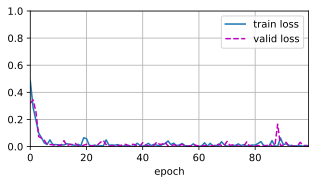

In [ ]:
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder0T().to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.00001, 
                             weight_decay=0)
trainoutput, validoutput = train_batch(model, trainimages, validimages, num_epochs, criterion, optimizer, device, 
                                       mode="l1", save_model="20220503_0T_trial.pt", load_model="new", 
                                       loss_log="20220503_0T_trial.csv", early_stopping="yes", patience=10)

## 6.4 Printer
Printer function for converting the outputs from the autoencoder (tensors) back to images for display.

In [ ]:
def trainprint(output):
  """ Printer for training and validaion sets
  `output`: Output from trainer
  """
  for i, item in enumerate(output):
    # move number of channels to the last dimension
    imgs_lab = torch.permute(item[0], (1,2,0)) # true image
    recon_lab = torch.permute(item[1], (1,2,0)) # predicted image
    bw = item[0][0] # greyscale version of true image

    imgs_lab = imgs_lab.to(torch.device("cpu")).detach().numpy()
    recon_lab = recon_lab.to(torch.device("cpu")).detach().numpy()
    bw = bw.to(torch.device("cpu")).detach().numpy()

    # Prepare greyscale version of true image for conversion
    bw_lab = torch.zeros((3,256,256))
    bw_lab[0,:,:] += bw
    # move number of channels to the last dimension
    bw_lab = torch.permute(bw_lab, (1,2,0))

    # convert from CIELAB to RGB
    imgs_rgb = color.lab2rgb(imgs_lab)
    recon_rgb = color.lab2rgb(recon_lab)
    bw_rgb = color.lab2rgb(bw_lab)

    # define plot to show all three images side by side
    fig, axarr = plt.subplots(nrows=1,ncols=3)
    axarr[0].imshow(imgs_rgb)
    axarr[1].imshow(recon_rgb)
    axarr[2].imshow(bw_rgb)
    
    # disable axes
    axarr[0].axis("off")
    axarr[1].axis("off")
    axarr[2].axis("off")

  plt.show()

## 6.5 Visualise the training set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


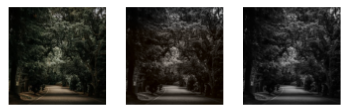

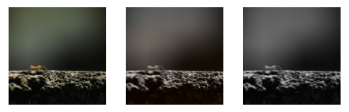

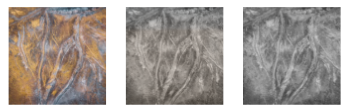

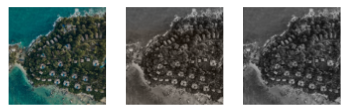

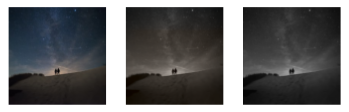

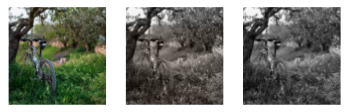

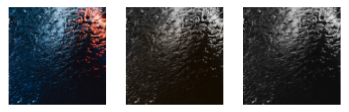

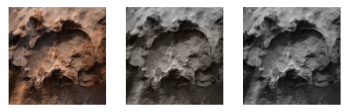

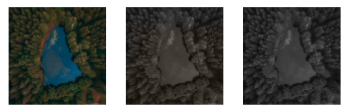

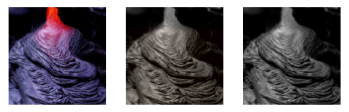

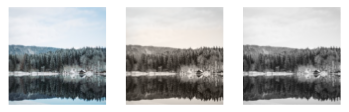

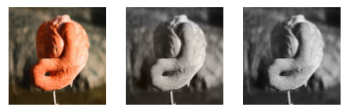

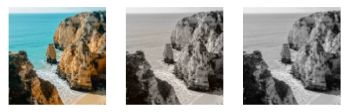

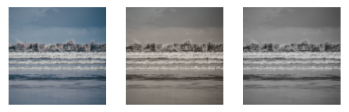

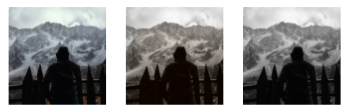

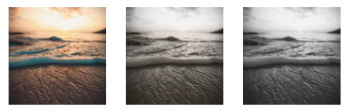

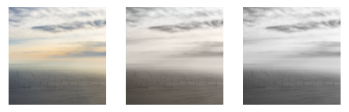

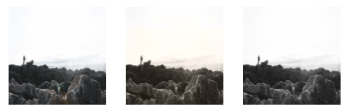

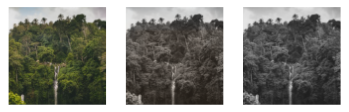

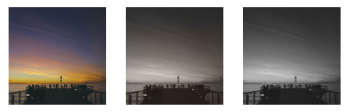

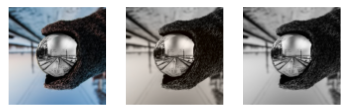

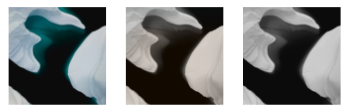

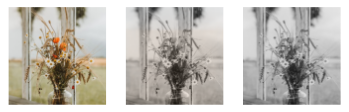

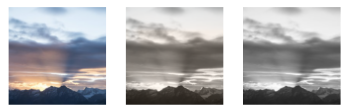

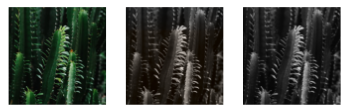

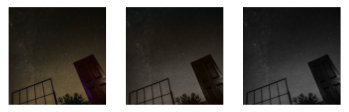

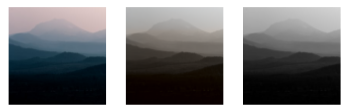

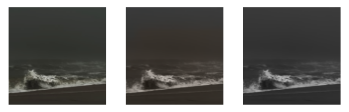

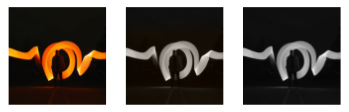

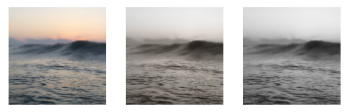

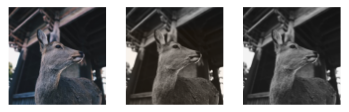

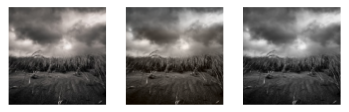

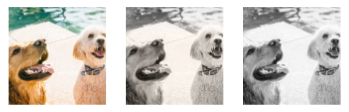

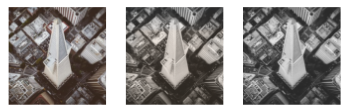

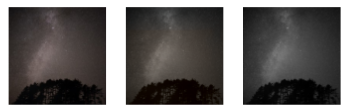

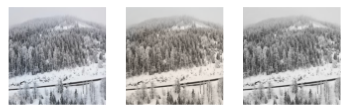

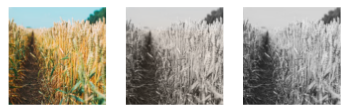

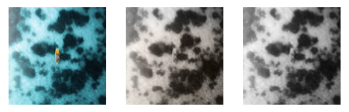

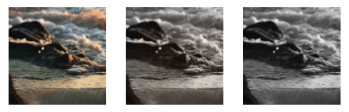

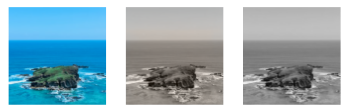

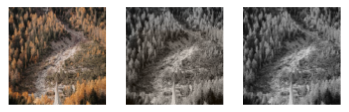

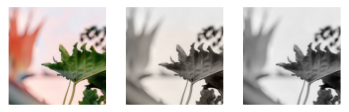

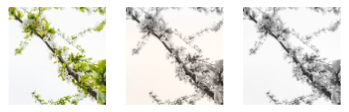

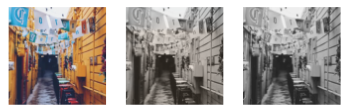

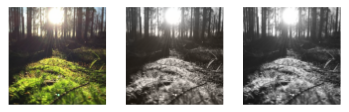

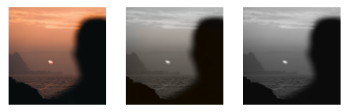

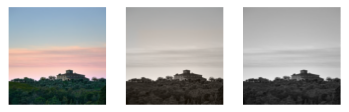

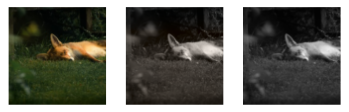

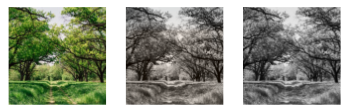

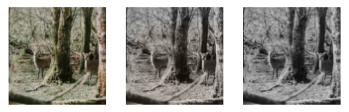

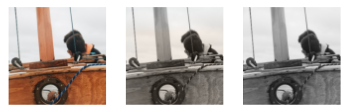

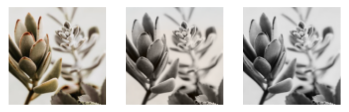

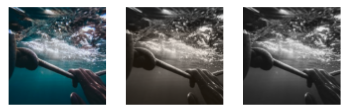

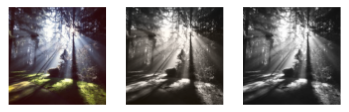

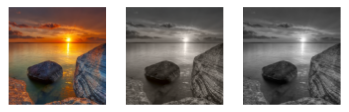

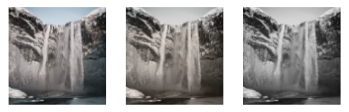

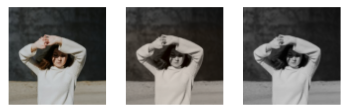

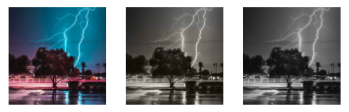

In [ ]:
trainprint(trainoutput[:])

## 6.6 Visualise the validation set

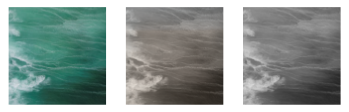

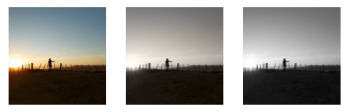

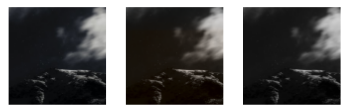

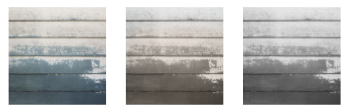

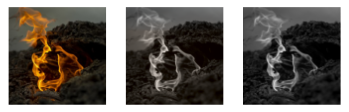

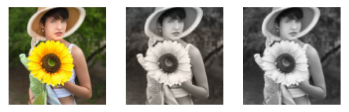

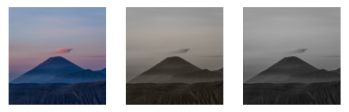

In [ ]:
trainprint(validoutput[:])

# 7. Testing

## 7.1 Upload images for testing
The following code allows the user to upload a ZIP archive of `jpg` greyscale images. Images will be unpacked from the ZIP file into a folder named `testimages` in the current working directory.

In [ ]:
uploaded = files.upload() 
filename = next(iter(uploaded))
file_dir = "./"+filename
extract_dir = "./testimages"
archive_format = "zip"
shutil.unpack_archive(file_dir, extract_dir, archive_format)

## 7.2 Resize folder of images
Function to resize a folder of images to 256x256 pixels. Images are cropped into a square with its aspect ratio maintained.

In [ ]:
def image_resizer(imgfolder):
  """ Resizes a folder of images to 256x256 pixels
  `imgfolder`: Path to a folder
  """
  pbar = tqdm(total=len(os.listdir(imgfolder)), position=0,
              bar_format="Resizing images: {n_fmt}/{total_fmt} ({percentage:3.0f}%) [{elapsed}/{remaining}]{bar}{desc}")
  for img in glob.glob(imgfolder+"/*.jpg"):
    _, filename = os.path.split(img)
    outname = os.path.join("./testimages2_resized/",filename)
    
    with Image.open(img) as im:
      pbar.set_description(f"Processing {filename}")
      width = im.width
      height = im.height
      # Image is already 256x256
      if width == 256 and height == 256:
        pass
      # Image is portrait or square
      elif height >= width:
        crop_box = (0, (height-width)//2, width, (height-width)//2 + width)
        im = im.resize(size = (256,256), box = crop_box)
      # Image is landscape
      else:
        crop_box = ((width-height)//2, 0, (width-height)//2 + height, height)
        im = im.resize(size = (256,256), box = crop_box)
      # Save
      pbar.update(1)
      im.save(outname)

In [ ]:
image_resizer("./testimages")

## 7.3 Prepare the dataloader

Prepare the resized images for use with the trained model. The images are processed as in the same way as for the training set. The two modes corresponds to whether the input is colour or greyscale images, for which a different set of outputs are produced.

In [ ]:
def loadtestimage(imgfolder, mode="bw"):
  """ Prepare images for testing 
  `imgfolder`: Path to a folder. All images must be 256x256 pixels.
  `mode` (optional, default: `bw`): `bw`: Input images are B/W. Returns 1x256x256 tensors. `colour`: Input images are colourful. Returns 1x256x256 + 2x256x256 tensors.
  """
  pbar = tqdm(total=len(os.listdir(imgfolder)) , position=0, 
                  bar_format="Importing images: {n_fmt}/{total_fmt} ({percentage:3.0f}%) [{elapsed}/{remaining}]{bar}{desc}")
  images = []
  for img in glob.glob(imgfolder+"/*.jpg"):
    if len(images) == count: break
    pbar.set_description(f"Processing {img}")
    NotLoaded = True
    while NotLoaded:
      try:
        im = imread(img)
        if mode =="bw":
          images.append(processimage_bw(im))
          pbar.update(1)
          NotLoaded = False
        elif mode == "colour":
          images.append(processimage_colour(im))
          pbar.update(1)
          NotLoaded = False
      except:
        pass
  return images

def processimage_bw(im):
  lab = color.rgb2lab(1.0 * im /255) # normalize from [0, 255] to [0, 1]
  lab = torch.Tensor(lab)
  lab = torch.permute(lab,(2,0,1)) # move number of channels to the 0-th dimension
  l = lab[0,:,:]
  l = torch.reshape(l,(1, 1, 256, 256)) #l channel
  return [l]

def processimage_colour(im):
  lab = color.rgb2lab(1.0 * im /255) # normalize from [0, 255] to [0, 1]
  lab = torch.Tensor(lab)
  lab = torch.permute(lab,(2,0,1)) # move number of channels to the 0-th dimension
  l = lab[0,:,:]
  l = torch.reshape(l,(1, 1, 256, 256)) #l channel
  ab = lab[1:,:,:]
  ab = ab/128 # normalise from [-128, 128] to [-1, 1]
  ab = torch.reshape(ab,(1, 2, 256, 256)) #a, b channels
  return [ab, l]

In [ ]:
test_images = loadtestimage("./testimages_resized")

## 7.4 Tester
Function to run the testing images with the trained model, and to print the trained output

### 7.4.1 Tester for B&W Inputs
Function returns six images for each colourful image input, corresponding to the predicted output of each of the five models, and the original greyscale version.

In [ ]:
def canvaspainter_bw(recon1, recon2, recon3, recon4, recon5, img_bw):
  # Create blank canvas
  pred1 = torch.zeros((3,256,256))
  pred2 = torch.zeros((3,256,256))
  pred3 = torch.zeros((3,256,256))
  pred4 = torch.zeros((3,256,256))
  pred5 = torch.zeros((3,256,256))
  img_bw = img_bw.reshape((256,256))

  # Construct predicted image 1
  pred1[0,:,:] += img_bw
  pred1[1:,:,:] += recon1[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  # Construct predicted image 2
  pred2[0,:,:] += img_bw
  pred2[1:,:,:] += recon2[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  # Construct predicted image 3
  pred3[0,:,:] += img_bw
  pred3[1:,:,:] += recon3[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  # Construct predicted image 4
  pred4[0,:,:] += img_bw
  pred4[1:,:,:] += recon4[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  # Construct predicted image 5
  pred5[0,:,:] += img_bw
  pred5[1:,:,:] += recon5[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]
  
  return (img_bw, pred1, pred2, pred3, pred4, pred5)

def tester_bw(model1, state1, model2, state2, model3, state3, model4, state4, model5, state5, images):
  checkpoint1 = torch.load(state1, map_location=torch.device("cpu"))
  model1.load_state_dict(checkpoint1["model_state_dict"])
  model1.eval()
  checkpoint2 = torch.load(state2, map_location=torch.device("cpu"))
  model2.load_state_dict(checkpoint2["model_state_dict"])
  model2.eval()
  checkpoint3 = torch.load(state3, map_location=torch.device("cpu"))
  model3.load_state_dict(checkpoint3["model_state_dict"])
  model3.eval()
  checkpoint4 = torch.load(state4, map_location=torch.device("cpu"))
  model4.load_state_dict(checkpoint4["model_state_dict"])
  model4.eval()
  checkpoint5 = torch.load(state5, map_location=torch.device("cpu"))
  model5.load_state_dict(checkpoint5["model_state_dict"])
  model5.eval()
  output = []
  criterion = nn.MSELoss(reduction="mean")
  device = torch.device("cpu")
  
  pbar = tqdm(total = len(images), leave=True, 
                  bar_format="Processing images: {n_fmt}/{total_fmt} ({percentage:3.0f}%) [{elapsed}/{remaining}] {bar}")
  
  with torch.no_grad():
    for i in images:
      img_bw = i[0]
      recon1 = model1(img_bw)
      recon2 = model2(img_bw)
      recon3 = model3(img_bw)
      recon4 = model4(img_bw)
      recon5, mu, logvar = model5(img_bw)
      output.append(canvaspainter_bw(recon1, recon2, recon3, recon4, recon5, img_bw))
      pbar.update(1)
    return output

def testprint(output):
  """ Printer for training and validaion sets
  `output`: Output from trainer
  """
  for i, item in enumerate(output):
    # move number of channels to the last dimension
    bw = item[0]
    recon1_lab = torch.permute(item[1], (1,2,0)) # predicted image
    recon2_lab = torch.permute(item[2], (1,2,0)) # predicted image
    recon3_lab = torch.permute(item[3], (1,2,0)) # predicted image
    recon4_lab = torch.permute(item[4], (1,2,0)) # predicted image
    recon5_lab = torch.permute(item[5], (1,2,0)) # predicted image

    bw = bw.detach().numpy()
    recon1_lab = recon1_lab.detach().numpy()
    recon2_lab = recon2_lab.detach().numpy()
    recon3_lab = recon3_lab.detach().numpy()
    recon4_lab = recon4_lab.detach().numpy()
    recon5_lab = recon5_lab.detach().numpy()

    # Prepare greyscale version of true image for conversion
    bw_lab = torch.zeros((3,256,256))
    bw_lab[0,:,:] += bw
    # move number of channels to the last dimension
    bw_lab = torch.permute(bw_lab, (1,2,0))

    # convert from CIELAB to RGB
    bw_rgb = color.lab2rgb(bw_lab)
    recon1_rgb = color.lab2rgb(recon1_lab)
    recon2_rgb = color.lab2rgb(recon2_lab)
    recon3_rgb = color.lab2rgb(recon3_lab)
    recon4_rgb = color.lab2rgb(recon4_lab)
    recon5_rgb = color.lab2rgb(recon5_lab)

    # define plot to show all images side by side
    fig, axarr = plt.subplots(nrows=1,ncols=6, figsize=(20,20))
    axarr[0].imshow(recon1_rgb)
    axarr[1].imshow(recon2_rgb)
    axarr[2].imshow(recon3_rgb)
    axarr[3].imshow(recon4_rgb)
    axarr[4].imshow(recon5_rgb)
    axarr[5].imshow(bw_rgb)
    
    # disable axes
    axarr[0].axis("off")
    axarr[1].axis("off")
    axarr[2].axis("off")
    axarr[3].axis("off")
    axarr[4].axis("off")
    axarr[5].axis("off")
    
  plt.show()

### 7.4.2 Tester for Colour Inputs
Function returns seven images for each colourful image input, corresponding to the ground truth, predicted output of each of the five models, and the greyscale version.

In [ ]:
def canvaspainter_colour(recon1, recon2, recon3, recon4, recon5, img_bw, img_ab):
  # Create blank canvas
  true = torch.zeros((3,256,256))
  pred1 = torch.zeros((3,256,256))
  pred2 = torch.zeros((3,256,256))
  pred3 = torch.zeros((3,256,256))
  pred4 = torch.zeros((3,256,256))
  pred5 = torch.zeros((3,256,256))
  img_bw = img_bw.reshape((256,256))

  # Construct predicted image 1
  pred1[0,:,:] += img_bw
  pred1[1:,:,:] += recon1[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  # Construct predicted image 2
  pred2[0,:,:] += img_bw
  pred2[1:,:,:] += recon2[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  # Construct predicted image 3
  pred3[0,:,:] += img_bw
  pred3[1:,:,:] += recon3[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  # Construct predicted image 4
  pred4[0,:,:] += img_bw
  pred4[1:,:,:] += recon4[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  # Construct predicted image 5
  pred5[0,:,:] += img_bw
  pred5[1:,:,:] += recon5[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  # Construct true image
  true[0,:,:] += img_bw
  true[1:,:,:] += true[0] * 128 # undo normalisation from [-1, +1] to [-128, +128]

  return (true, pred1, pred2, pred3, pred4, pred5)

def tester_colour(model1, state1, model2, state2, model3, state3, model4, state4, model5, state5, images):
  checkpoint1 = torch.load(state1, map_location=torch.device("cpu"))
  model1.load_state_dict(checkpoint1["model_state_dict"])
  model1.eval()
  checkpoint2 = torch.load(state2, map_location=torch.device("cpu"))
  model2.load_state_dict(checkpoint2["model_state_dict"])
  model2.eval()
  checkpoint3 = torch.load(state3, map_location=torch.device("cpu"))
  model3.load_state_dict(checkpoint3["model_state_dict"])
  model3.eval()
  checkpoint4 = torch.load(state4, map_location=torch.device("cpu"))
  model4.load_state_dict(checkpoint4["model_state_dict"])
  model4.eval()
  checkpoint5 = torch.load(state5, map_location=torch.device("cpu"))
  model5.load_state_dict(checkpoint5["model_state_dict"])
  model5.eval()
  output = []
  criterion = nn.MSELoss(reduction="mean")
  device = torch.device("cpu")
  
  pbar = tqdm(total = len(images), leave=True, 
                  bar_format="Processing images: {n_fmt}/{total_fmt} ({percentage:3.0f}%) [{elapsed}/{remaining}] {bar}")
  
  with torch.no_grad():
    for i in images:
      img_ab = i[0]
      img_bw = i[1]
      recon1 = model1(img_bw)
      recon2 = model2(img_bw)
      recon3 = model3(img_bw)
      recon4 = model4(img_bw)
      recon5, mu, logvar = model5(img_bw)
      output.append(canvaspainter_colour(recon1, recon2, recon3, recon4, recon5, img_bw, img_ab))
      pbar.update(1)
    return output

def trainprint(output):
  """ Printer for training and validaion sets
  `output`: Output from trainer
  """
  for i, item in enumerate(output):
    # move number of channels to the last dimension
    imgs_lab = torch.permute(item[0], (1,2,0)) # true image
    recon1_lab = torch.permute(item[1], (1,2,0)) # predicted image
    recon2_lab = torch.permute(item[2], (1,2,0)) # predicted image
    recon3_lab = torch.permute(item[3], (1,2,0)) # predicted image
    recon4_lab = torch.permute(item[4], (1,2,0)) # predicted image
    recon5_lab = torch.permute(item[5], (1,2,0)) # predicted image
    bw = item[0][0] # greyscale version of true image

    imgs_lab = imgs_lab.detach().numpy()
    recon1_lab = recon1_lab.detach().numpy()
    recon2_lab = recon2_lab.detach().numpy()
    recon3_lab = recon3_lab.detach().numpy()
    recon4_lab = recon4_lab.detach().numpy()
    recon5_lab = recon5_lab.detach().numpy()
    bw = bw.detach().numpy()

    # Prepare greyscale version of true image for conversion
    bw_lab = torch.zeros((3,256,256))
    bw_lab[0,:,:] += bw
    # move number of channels to the last dimension
    bw_lab = torch.permute(bw_lab, (1,2,0))

    # convert from CIELAB to RGB
    imgs_rgb = color.lab2rgb(imgs_lab)
    recon1_rgb = color.lab2rgb(recon1_lab)
    recon2_rgb = color.lab2rgb(recon2_lab)
    recon3_rgb = color.lab2rgb(recon3_lab)
    recon4_rgb = color.lab2rgb(recon4_lab)
    recon5_rgb = color.lab2rgb(recon5_lab)
    bw_rgb = color.lab2rgb(bw_lab)

    # define plot to show all three images side by side
    fig, axarr = plt.subplots(nrows=1,ncols=7, figsize=(20,20))
    axarr[0].imshow(imgs_rgb)
    axarr[1].imshow(recon1_rgb)
    axarr[2].imshow(recon2_rgb)
    axarr[3].imshow(recon3_rgb)
    axarr[4].imshow(recon4_rgb)
    axarr[5].imshow(recon5_rgb)
    axarr[6].imshow(bw_rgb)
    
    # disable axes
    axarr[0].axis("off")
    axarr[1].axis("off")
    axarr[2].axis("off")
    axarr[3].axis("off")
    axarr[4].axis("off")
    axarr[5].axis("off")
    axarr[6].axis("off")
    
  plt.show()

## 7.5 Testing
Testing on images not trained on

In [ ]:
model1 = Autoencoder0()
model2 = Autoencoder0T()
model3 = Autoencoder1()
model4 = Autoencoder2()
model5 = Autoencoder2V()
state1 = "20220430_0_l1_1000.pt"
state2 = "20220501_0T_l1_1000.pt"
state3 = "20220429_1_l1n"
state4 = "20220430_2_l1"
state5 = "20220501_2v.pt"

#output = tester_bw(model1, state1, model2, state2, model3, state3, model4, state4, model5, state5, test_images)
output = tester_colour(model1, state1, model2, state2, model3, state3, model4, state4, model5, state5, test_images)

## 7.6 Visualise the testing set

In [ ]:
#Use trainprint if your input is colourful - this will return predicted colours and average MSE loss
trainprint(output)

#Use testprint if your input if B&W - this will return predict colours only
# testprint(output)